In [2]:
# 필요 라이브러리 install
! pip install xgboost
! pip install optuna
! pip install lightgbm

In [3]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")

C:\Users\skaeh\Anaconda3\envs\ZDRSJ\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
'''from google.colab import drive
drive.mount('/gdrive', force_remount=True)

import pandas as pd

data_file= '/gdrive/My Drive/Colab Notebooks/경로폴더/ml_data.csv'
df= pd.read_csv(data_file) '''

"from google.colab import drive\ndrive.mount('/gdrive', force_remount=True)\n\nimport pandas as pd\n\ndata_file= '/gdrive/My Drive/Colab Notebooks/경로폴더/ml_data.csv'\ndf= pd.read_csv(data_file) "

In [5]:
# 데이터 불러오기
df = pd.read_csv('../data/ML_data_final.csv')

df

,Unnamed: 0,year,area,price,버스노선수,가좌동,고양동,관산동,대화동,덕은동,...,주교동,주엽동,중산동,지축동,탄현동,토당동,풍동,행신동,향동동,화정동
0,0,2012,59,21356,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2012,84,25238,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2012,101,30607,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2012,124,37333,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2012,153,38075,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11306,11306,2021,129,75000,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11307,11307,2021,53,41925,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11308,11308,2021,59,54263,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11309,11309,2021,59,59885,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
df.drop('Unnamed: 0', axis=1, inplace= True)
df.head(5)

,year,area,price,버스노선수,가좌동,고양동,관산동,대화동,덕은동,덕이동,...,주교동,주엽동,중산동,지축동,탄현동,토당동,풍동,행신동,향동동,화정동
0,2012,59,21356,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012,84,25238,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012,101,30607,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012,124,37333,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012,153,38075,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# train-test분리
cut = int(len(df)*0.8) # traun, valid 80:20 으로 split
train_tmp = df[:cut]
test = df[cut:]
df = train_tmp

In [8]:
# train 데이터셋 분할
train_X = test.drop('price', axis=1)
train_y = test['price']

print(train_X.shape, train_y.shape)

(2263, 32) (2263,)


In [9]:
# 교차 검증 
# 모델 선정 위해 (XGB, LGB) 모델의 성능 비교
'''
 시계열 데이터 - TimeSeriesSplit 기법을 사용
 10개의 폴드로 구분
  1) 과거의 데이터부터 끊어서 학습
  2) 다음 폴드부터 이전 폴드까지 이용하여 반복적으로 교차검증
  3) 미래의 데이터는 절대 학습하지 않으며 무조건 검증으로 사용됨
'''


def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5 
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10) # 10개의 폴드로 구분
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [10]:
# XGB, LGB 모델 설정 
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [11]:
models = []
scores = []
for model in [model_xgb, model_lgb]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

XGBRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\skaeh\Anaconda3\envs\ZDRSJ\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
XGBRegressor Cross Validations...:  10%|█         | 1/10 [00:01<00:11,  1.29s/it]C:\Users\skaeh\Anaconda3\envs\ZDRSJ\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:02<00:10,  1.35s/it]C:\Users\skaeh\Anaconda3\envs\ZDRSJ\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use 

1 FOLDS: XGBRegressor RMSLE: 40944.4618
2 FOLDS: XGBRegressor RMSLE: 19832.9598
3 FOLDS: XGBRegressor RMSLE: 18240.8667
4 FOLDS: XGBRegressor RMSLE: 17311.0950
5 FOLDS: XGBRegressor RMSLE: 17668.0520
6 FOLDS: XGBRegressor RMSLE: 21826.8613
7 FOLDS: XGBRegressor RMSLE: 15339.7923
8 FOLDS: XGBRegressor RMSLE: 18606.4596
9 FOLDS: XGBRegressor RMSLE: 18781.7127
10 FOLDS: XGBRegressor RMSLE: 13806.0125

XGBRegressor mean RMSLE: 20235.8274


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

1 FOLDS: LGBMRegressor RMSLE: 21867.7218
2 FOLDS: LGBMRegressor RMSLE: 22120.3163
3 FOLDS: LGBMRegressor RMSLE: 21690.5947
4 FOLDS: LGBMRegressor RMSLE: 14390.6317
5 FOLDS: LGBMRegressor RMSLE: 24023.9039
6 FOLDS: LGBMRegressor RMSLE: 22931.3337
7 FOLDS: LGBMRegressor RMSLE: 16185.3063
8 FOLDS: LGBMRegressor RMSLE: 17742.4092
9 FOLDS: LGBMRegressor RMSLE: 16828.0095
10 FOLDS: LGBMRegressor RMSLE: 12836.0190

LGBMRegressor mean RMSLE: 19061.6246


In [12]:
# 모델 성능 비교
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,XGBRegressor,20235.827366
1,LGBMRegressor,19061.624607


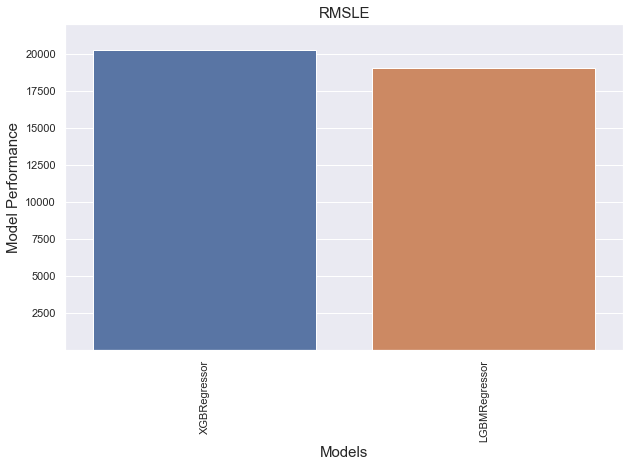

In [13]:
# 모델 성능 시각화하여 확인
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 22000)
plt.title('RMSLE', fontsize=15)
plt.show()

In [14]:
# train, valid split 
cut = int(len(df)*0.8) # traun, valid 80:20 으로 split
train = df[:cut]
valid = df[cut:]

train_X = train.drop('price', axis=1)
train_y = train['price']
valid_X = valid.drop('price', axis=1)
valid_y = valid['price']
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)

(7238, 32) (7238,) (1810, 32) (1810,)


In [15]:
train_X.head()

,year,area,버스노선수,가좌동,고양동,관산동,대화동,덕은동,덕이동,도내동,...,주교동,주엽동,중산동,지축동,탄현동,토당동,풍동,행신동,향동동,화정동
0,2012,59,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012,84,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012,101,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012,124,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012,153,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# 하이퍼 파라미터 튜닝
# 시간 이슈 때문에 TimeSeriesSplit은 적용하지 않음
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(train_X, label=train_y)
    dtest = lgb.Dataset(valid_X, label=valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(train_X, train_y, eval_set=[(valid_X, valid_y)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(valid_y, lgb_model.predict(valid_X))
    return rmse
       
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-03-27 20:36:20,650] A new study created in memory with name: no-name-142d25ca-1aa0-47e5-815c-6779498d5121
C:\Users\skaeh\Anaconda3\envs\ZDRSJ\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\skaeh\Anaconda3\envs\ZDRSJ\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-03-27 20:36:23,610] Trial 0 finished with value: 17652.22089227252 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimat

In [17]:
# val 검증
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 7379.108120626914,
params {'max_depth': 11, 'learning_rate': 0.0069271447880488056, 'n_estimators': 2741, 'min_child_samples': 11, 'subsample': 0.626937600270061}


In [18]:
# test 데이터셋 분할
test_X = test.drop('price', axis=1)
test_y = test['price']

In [19]:
# 데이터에 LightGBM model 적용
final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_X)

In [20]:
final_lgb_pred

array([43003.93525724, 49888.57197967, 57309.57914698, ...,
       29173.54144974, 29173.54144974, 25117.26537649])

In [21]:
# 평가지표 출력
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print('R2 : {:.3f}'.format(r2_score(test_y, final_lgb_pred)))
print('MSE : {:.3f}'.format(mean_squared_error(test_y, final_lgb_pred)))
print('MAE : {:.3f}'.format(mean_absolute_error(test_y, final_lgb_pred)))
print('RMSE : {:.3f}'.format(np.sqrt(mean_squared_error(test_y, final_lgb_pred))))

R2 : 0.388
MSE : 526101108.027
MAE : 15284.073
RMSE : 22936.894


In [22]:
score = rmse_cv(final_lgb_model)
score

LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


('LGBMRegressor',
 [7852.41241272786,
  9300.657959344613,
  5633.307000045669,
  5192.408204042359,
  4699.285961304424,
  6193.85562165112,
  5533.554588523457,
  10139.73111651682,
  6457.15829080486,
  5955.439610340914])

In [23]:
final_lgb_pred

array([43003.93525724, 49888.57197967, 57309.57914698, ...,
       29173.54144974, 29173.54144974, 25117.26537649])

In [24]:
# plt 한글 폰트 깨짐 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

'sudo'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'sudo'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'rm'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [25]:
# 폰트 및 그래프 크기 설정
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
plt.rcParams["figure.figsize"] = [20, 15]

<BarContainer object of 32 artists>

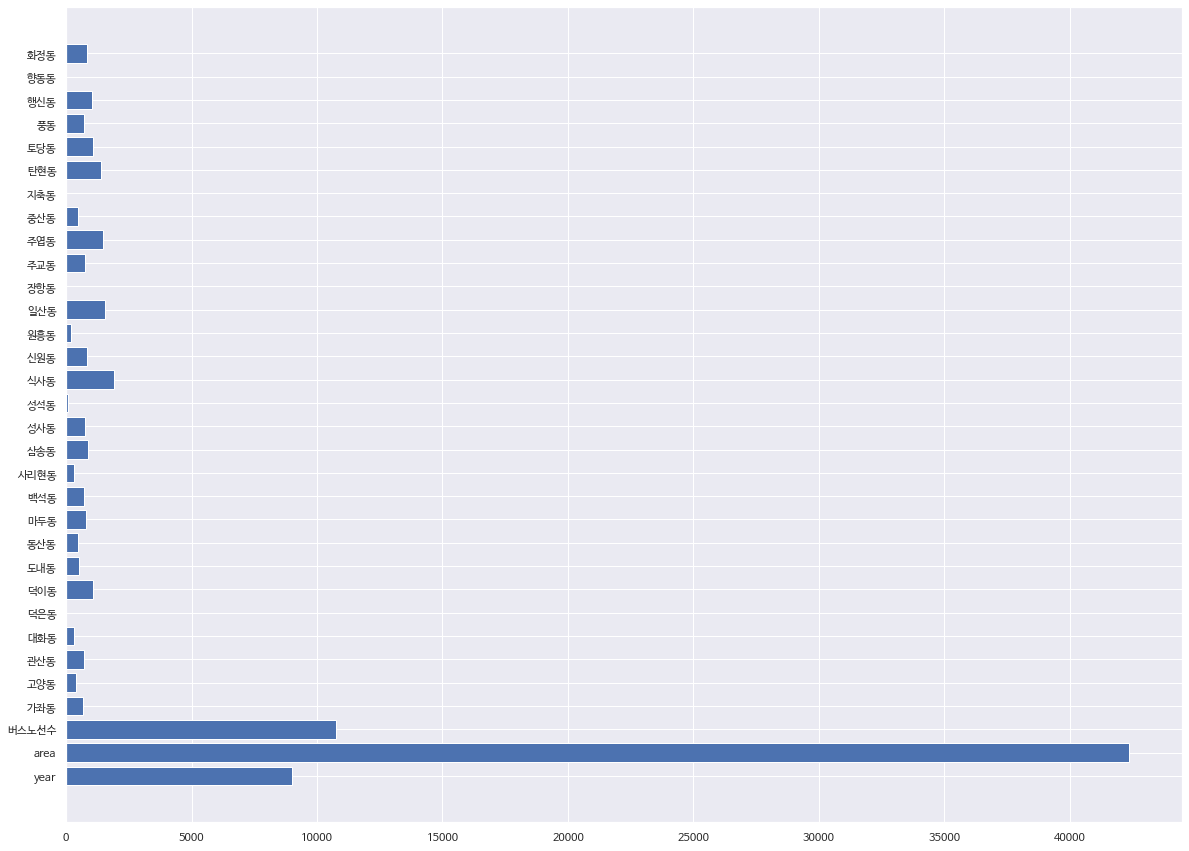

In [26]:
# 그래프 출력
plt.barh(train_X.columns, final_lgb_model.feature_importances_)

In [27]:
# 학습시킨 모델 저장하기
import joblib

joblib.dump(final_lgb_model, './final_model.pkl')

# 피클파일 다시 불러오기
modelReload = joblib.load('final_model.pkl')

import pickle

with open('final_model.pkl', 'wb') as pickle_file:
    pickle.dump(final_lgb_model, pickle_file)

In [28]:
# 예측 값 출력 예비 테스트
def make_bus_dict(dong):
    '''버스 노선 사전에서 동(key)를 넣으면 노선수(value)를 리턴하는 함수'''
    # 버스 노선 파일 불러오기
    bus_line_data = pd.read_excel("../data/bus_line_data.xlsx")

    # 각 컬럼별 값들 리스트로 만들기
    adr_dong = list(bus_line_data['adr_dong'])
    bus_num = list(bus_line_data['버스노선수'])

    # dict로 키-값 형태로 저장하기
    bus_dict = {}

    for i in range(0, len(adr_dong)):
        bus_dict[adr_dong[i]] = bus_num[i]

    return bus_dict[dong]


data_dong = '고양동'
data_year = 2023
data_area = 85

# 버스노선수 dict에서 뽑기
data_bus = make_bus_dict(data_dong)

temp = {
    'year' : data_year,
    '전용면적' : data_area,
    '버스노선수' : data_bus,
    '가좌동' : 0,
    '고양동' : 0,
    '관산동' : 0,
    '대화동' : 0,
    '덕은동' : 0,
    '덕이동' : 0,
    '도내동' : 0,
    '동산동' : 0,
    '마두동' : 0,
    '백석동' : 0,
    '사리현동' : 0,
    '삼송동' : 0,
    '성사동' : 0,
    '성석동' : 0,
    '식사동' : 0,
    '신원동' : 0,
    '원흥동' : 0,
    '일산동' : 0,
    '장항동' : 0,
    '주교동' : 0,
    '주엽동' : 0,
    '중산동' : 0,
    '지축동' : 0,
    '탄현동' : 0,
    '토당동' : 0,
    '풍동' : 0,
    '행신동' : 0,
    '향동동' : 0,
    '화정동' : 0
}

# 해당 동은 1로 바꿔주기
temp[data_dong] = 1

# dataframe(series) 형태로 변환
data_f = pd.DataFrame([temp])

# model에 넣어서 예측값 구하기
modelReload.predict(data_f)

array([31706.00542664])